This notebook gives intuition about the basics of Bayesian inference. This first example is borrowed from Cam Davidson-Pilon's online book, Probabilistic Programming & Bayesian Methods for Hackers (https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers)

95% highest posterior density interval
0 tosses [0.010101010101010102, 1.0]
1 tosses [0.0, 0.76767676767676774]
2 tosses [0.0, 0.60606060606060608]
3 tosses [0.0, 0.49494949494949497]
4 tosses [0.0, 0.4141414141414142]
5 tosses [0.020202020202020204, 0.59595959595959602]
6 tosses [0.12121212121212122, 0.68686868686868696]
7 tosses [0.30303030303030304, 0.75757575757575768]
8 tosses [0.36363636363636365, 0.6262626262626263]
9 tosses [0.45454545454545459, 0.53535353535353536]


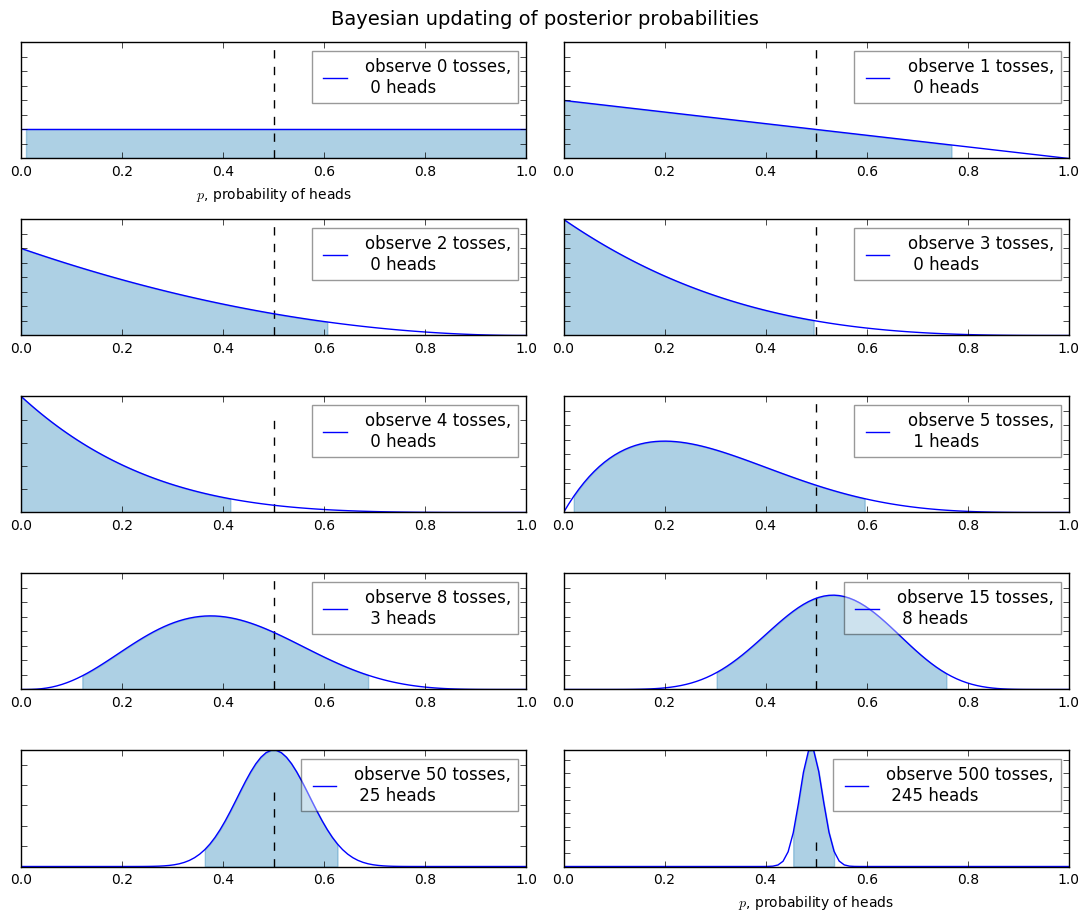

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
import numpy
from matplotlib import pyplot as plt
figsize(11, 9)

import scipy.stats as stats

dist = stats.beta
n_trials = [0, 1, 2, 3, 4, 5, 8, 15, 50, 500]
data = stats.bernoulli.rvs(0.5, size=n_trials[-1])
x = np.linspace(0, 1, 100)

def hpd(x,y,pct):
    """
    return indices for highest posterior density from array
    """
    idx=numpy.argsort(y)[::-1]
    sorted_data=y[idx]

    hits=idx[numpy.where(numpy.cumsum(sorted_data)<=pct)[0]]
    return [x[numpy.min(hits)],x[numpy.max(hits)]],hits

print ('95% highest posterior density interval')
# For thealready prepared, I'm using Binomial's conj. prior.
for k, N in enumerate(n_trials):
    sx = plt.subplot(len(n_trials) / 2, 2, k + 1)
    plt.xlabel("$p$, probability of heads") \
        if k in [0, len(n_trials) - 1] else None
    plt.setp(sx.get_yticklabels(), visible=False)
    heads = data[:N].sum()
    y = dist.pdf(x, 1 + heads, 1 + N - heads)
    # compute the 95% highest posterior density
    hpdint,hpdhits=hpd(x,y,95)
    hpdhits=numpy.sort(hpdhits)
    print (k,'tosses',hpdint)
    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x[hpdhits], 0, y[hpdhits], color="#348ABD", alpha=0.4)
    plt.vlines(0.5, 0, 4, color="k", linestyles="--", lw=1)

    leg = plt.legend()
    leg.get_frame().set_alpha(0.4)
    plt.autoscale(tight=True)


plt.suptitle("Bayesian updating of posterior probabilities",
             y=1.02,
             fontsize=14)

plt.tight_layout()

Now let's look at the relation of classical and Bayesian inference, in the context of linear regression. This presentation borrows heavily from http://www.stats.ox.ac.uk/~cholmes/Courses/BDA/bda_mcmc.pdf

First let's generate some data, using the same code we used in the machine learning example.

r= 0.719247697153


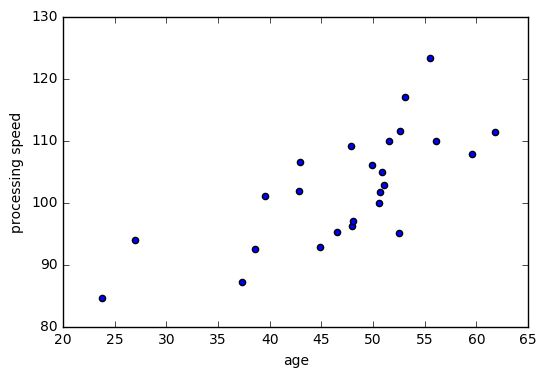

In [2]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats

def make_continuous_data(mean=[45,100],var=[10,10],cor=0.6,N=100):
    """
    generate a synthetic data set with two variables
    """
    cor=numpy.array([[1.,cor],[cor,1.]])
    var=numpy.array([[var[0],0],[0,var[1]]])
    cov=var.dot(cor).dot(var)
    return numpy.random.multivariate_normal(mean,cov,N)

n=25
d=make_continuous_data(N=n)
plt.scatter(d[:,0],d[:,1])
plt.xlabel('age')
plt.ylabel('processing speed')
print ('r=',numpy.corrcoef(d.T)[0,1])

Now we compute both standard GLM (using ordinary least squares) and Bayesian estimates for the regression, varying the prior variance on the parameters.

beta_hat (GLM): [   0.73957733  102.36703448]


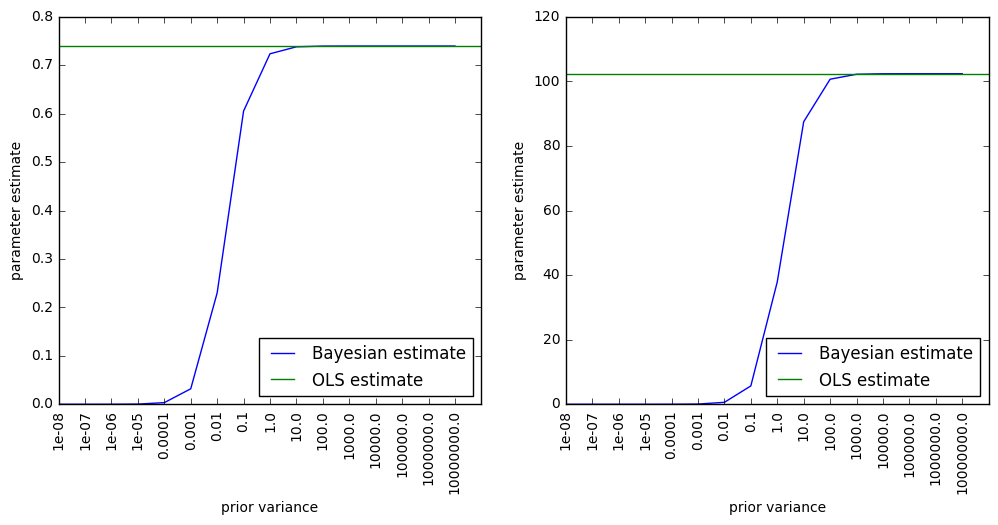

In [3]:
y=d[:,1]
X=numpy.vstack((d[:,0]-numpy.mean(d[:,0]),numpy.ones(d.shape[0]))).T
sigma2=1  # this is the variance - just set to 1 for this example

priorvals=10.**numpy.arange(-8,8)

bhat_bayes=numpy.zeros((len(priorvals),2))

bhat_glm=numpy.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
resid=y - X.dot(bhat_glm)
df=(X.shape[0] - X.shape[1])
mse=resid.dot(resid)
sigma2hat=(mse)/float(df)

print ('beta_hat (GLM):',bhat_glm)
for i in range(len(priorvals)):
    prior_variance=priorvals[i]
    v=numpy.identity(2)*prior_variance 


    bhat_bayes[i,:]=numpy.linalg.inv(X.T.dot(X) + (sigma2hat/prior_variance)*numpy.identity(2)).dot(X.T.dot(y))

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(range(len(priorvals)),bhat_bayes[:,0])
plt.xticks(range(len(priorvals)),priorvals, rotation='vertical')
plt.xlabel('prior variance')
plt.ylabel('parameter estimate')
plt.plot([0,len(priorvals)],[bhat_glm[0],bhat_glm[0]],color='green')
plt.legend(['Bayesian estimate','OLS estimate'],loc=4)
plt.subplot(122)
plt.plot(range(len(priorvals)),bhat_bayes[:,1])
plt.xticks(range(len(priorvals)),priorvals, rotation='vertical')
plt.xlabel('prior variance')
plt.ylabel('parameter estimate')
plt.plot([0,len(priorvals)],[bhat_glm[1],bhat_glm[1]],color='green')
plt.legend(['Bayesian estimate','OLS estimate'],loc=4)

Note that as the prior variance increases, the parameter estimate converges to the same estimate as OLS.